# Dynamic Traffic Management with Qutrits



In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import random
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from scipy.optimize import curve_fit
import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import SamplePulse

from qiskit import IBMQ 
IBMQ.load_account() 
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main") 
backend = provider.get_backend("ibmq_armonk") 
backend_config = backend.configuration()


configrc.store_credentials:WARNING:2021-04-11 08:31:01,089: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-04-11 08:31:01,286: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
class TrafficGrid:
    def __init__(self, x_length, y_length, p_left, p_right):
        """Data structure for a 2-dimensional traffic grid that can be
        represented as a (x_length * y_length) grid of nodes (intersections),
        (x_length - 1) * y_length North/South roads, and
        (y_length - 1) * x_length East/West roads.

        p_left is the probability of a car turning left at any 3-pronged intersection,
        and p_right is the probability of a car turning right at any 3-pronged
        intersection. These are used probabilistically to optimize how much
        pressure the next time period will result in for the system. In large-scale
        implementation, these could be implemented as an array with specific
        approximations for each intersection in the grid for more accuracy.
        Probability of proceeding straight is assumed 1 - p_left - p_right.
        """

        self.x_length = x_length
        self.y_length = y_length

        self.p_left = p_left
        self.p_right = p_right
        self.p_straight = 1 - p_left - p_right

        # Lists of street values from grid, vehicle weights & pedestrian weights
        self.ns_streets = [[] for i in range(x_length)]
        self.n_weights = [[] for i in range(x_length)]
        self.s_weights = [[] for i in range(x_length)]

        self.ew_streets = [[] for i in range(y_length)]
        self.e_weights = [[] for i in range(y_length)]
        self.w_weights = [[] for i in range(y_length)]

    def add_ns_streets(self, streets):
        """Method to populate the traffic grid with North/South streets.
        Streets is a list of lists, where each list is a column, and the
        contents include which segments of the column are valid streets.

        E.g. streets = [[0, 1], [0, 1, 2]] indicates two blocks in the first
        column, and three blocks from the second column.
        """
        self.ns_streets = streets
        self.n_weights = [[0 for i in j] for j in streets]
        self.s_weights = [[0 for i in j] for j in streets]

    def add_ew_streets(self, streets):
        """Method to populate the traffic grid with East/West streets.
        Streets is a list of lists, where each list is a column, and the
        contents include which segments of the column are valid streets.
        """
        self.ew_streets = streets
        self.e_weights = [[0 for i in j] for j in streets]
        self.w_weights = [[0 for i in j] for j in streets]

    def add_n_weight(self, column, street, weight):
        self.n_weights[column][street] += weight

    def add_s_weight(self, column, street, weight):
        self.s_weights[column][street + 1] += weight

    def add_e_weight(self, row, street, weight):
        self.e_weights[row][street] += weight

    def add_w_weight(self, row, street, weight):
        self.w_weights[row][street] += weight

    def add_n_pweight(self, column, street, weight):
        self.n_pweights[column][street] += weight

    def add_s_pweight(self, column, street, weight):
        self.s_pweights[column][street + 1] += weight

    def add_e_pweight(self, row, street, weight):
        self.e_pweights[row][street] += weight

    def add_w_pweight(self, row, street, weight):
        self.w_pweights[row][street] += weight

    def intersections(self):
        """Produces list of intersections"""
        intersections = set()
        for i, column in enumerate(self.ns_streets):
            for street in column:
                n_node = (self.x_length * street) + i
                s_node = (self.x_length * (street + 1)) + i
                intersections.add(n_node)
                intersections.add(s_node)

        for i, row in enumerate(self.ew_streets):
            for j, street in enumerate(row):
                e_node = (self.x_length * i) + street
                w_node = (self.x_length * i) + street + 1
                intersections.add(e_node)
                intersections.add(w_node)

        return intersections

    def edges(self):
        """Produces list of edges/weights"""
        edges = []
        for i, column in enumerate(self.ns_streets):
            for j, street in enumerate(column):
                n_weight = self.n_weights[i][j]
                s_weight = self.s_weights[i][j]

                n_node = (self.x_length * street) + i
                s_node = (self.x_length * (street + 1)) + i
                edges.append((n_node, s_node, s_weight))
                edges.append((s_node, n_node, n_weight))

        for i, row in enumerate(self.ew_streets):
            for j, street in enumerate(row):
                e_weight = self.e_weights[i][j]
                w_weight = self.w_weights[i][j]

                e_node = (self.x_length * i) + street
                w_node = (self.x_length * i) + street + 1
                edges.append((e_node, w_node, w_weight))
                edges.append((w_node, e_node, e_weight))

        return edges

    def graph(self):
        """Creates & plots a bidirectional graph object of intersections
        (as nodes) connected by two-directional streets (as edges).
        """
        G = nx.DiGraph()
        G.add_nodes_from(self.intersections())
        G.add_weighted_edges_from(self.edges())

        # Generate plot of the Graph
        colors  = ["r" for node in G.nodes()]
        default_axes = plt.axes(frameon=True)
        pos = nx.spring_layout(G)

        nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, 
                        ax=default_axes, pos=pos)
        return G

    def meshgrid(self, step_size=0.1):
        """Plots a 3D map to indicate ground state graphically.
        Source: IBM Qiskit QAOA Documentation.
        """
        # Evaluate the function
        a_gamma = np.arange(0, np.pi, step_size)
        a_beta = np.arange(0, np.pi, step_size)
        a_gamma, a_beta = np.meshgrid(a_gamma, a_beta)

        F1_1 = np.sin(2 * a_beta)**2 * np.sin(2 * a_gamma)**2 
        F1_1 -= 0.5 * np.sin(4 * a_beta) * np.sin(4 * a_gamma)
        F1_2 = 1 + np.cos(4 * a_gamma)**2
        F1 = 3 - (F1_1 * F1_2)

        # Grid search for the minimizing variables
        result = np.where(F1 == np.amax(F1))
        a = list(zip(result[0], result[1]))[0]

        gamma = a[0] * step_size
        beta = a[1] * step_size

        # Plot the expectation value F1
        fig = plt.figure()
        ax = Axes3D(fig)

        surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, 
                                linewidth=0, antialiased=True)

        ax.set_zlim(1,4)
        ax.zaxis.set_major_locator(LinearLocator(3))
        ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
        plt.show()

        # The smallest parameters and the expectation can be extracted
        print("\n --- OPTIMAL PARAMETERS --- \n")
        print(f"The maximal expectation value is: M1 = {np.amax(F1):.03f}")
        print(f"This is attained for gamma = {gamma:.03f} and {beta:.03f}")


In [10]:
grid = TrafficGrid(3, 4, 0.25, 0.25)
grid.add_ns_streets([[0, 1], [0, 1, 2], [0, 1, 2]])
grid.add_ew_streets([[0, 1], [0], [0, 1], [0, 1]])
grid.add_n_weight(1, 2, 1)
grid.add_e_weight(3, 0, 1)

In [11]:
grid

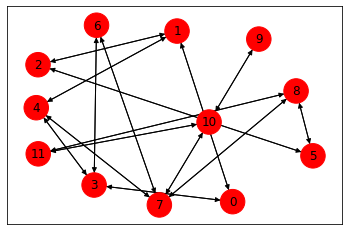

In [13]:
grid.graph()

In [14]:
dt = backend_config.dt
backend_defaults = backend.defaults()

In [27]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds
qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
# Drive pulse parameters (us = microseconds)
# This determines the actual width of the gaussian
drive_sigma_us = 0.075

# This is a truncating parameter, because gaussians don't have a natural finite length
drive_samples_us = drive_sigma_us * 8

def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

Qubit 0 has an estimated frequency of 4.971857898749946 GHz.


In [32]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data
def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

In [38]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [39]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [40]:
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.3)


The frequency sweep will go from 4.951857898749947 GHz to 4.991857898749947 GHz using 75 frequencies. The drive power is 0.3.


In [42]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [ ]:
# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.3)

In [ ]:
ground_freq_sweep_job = backend.run(ground_freq_sweep_program)

In [ ]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # Time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt * drive_samples, drive_samples)
    # No amplitude for the sine
    sine_pulse = np.sin(2 * np.pi * (freq - cal_qubit_freq) * t_samples) 

    # Create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = SamplePulse(np.multiply(np.real(pulse.samples), sine_pulse), 
                                    name='sideband_pulse')
    
    return sideband_pulse  

# More would be implemented above to create a distinguisher for the three
# orthogonal quantum states, but we unfortunately don't have the time nor
# resources to do a thorough implementation at the moment.


# Prepare the quantum and classical registers

c

In [ ]:
class QAOA():
    def __init__(self, grid, p, epsilon, eta):
        """Quantum Appoximate Optimization Algorithm implementation for
        Traffic Grid data structure with 3-level quantum state options.
        p is the number of QAOA layers in the circuit.
        Epsilon is the stepsize parameter for calculating the gradient,
        and Eta is the stepsize parameter for jumps in gradient descent.
        """
        self.grid = grid
        self.G = grid.graph()
        self.nodes = grid.intersections()
        self.edges = grid.edges()
        self.n = len(nodes)
        self.p = p
        self.epsilon = epsilon
        self.eta = eta

    def initialize(self, circuit):
        """Apply the layer of Hadamard gates to all qubits."""
        circuit.h(range(self.n))
        circuit.barrier()

    def hamiltonians(self, circuit, gammas, betas):
        """Apply the Ising type gates with learned gamma/beta, 
        for p number of layers of QAOA.# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])
        """

        for i in range(self.p):
            gamma = gammas[i]
            beta = betas[i]
            for edge in E:
                j = edge[0]
                k = edge[1]
                circuit.cp(-2 * gamma, j, k)
                circuit.p(gamma, j)
                circuit.p(gamma, k)
    
            # Apply the single qubit X rotations
            circuit.barrier()
            circuit.rx(2 * beta, range(self.n))

        # Finally measure the result in the computational basis
        circuit.barrier()
        circuit.measure(range(self.n), range(self.n))

    def draw(self, circuit):
        """Draw the circuit for comparison"""
        circuit.draw()

    def cost_function(self, x):
        """Cost of a certain allocation of states, specifically:
        |0> : intersection open for North/South traffic.
        |1> : intersection open for East/West traffic.
        |2> : intersection red lighted, open for pedestrians.

        Cost is for a single street connecting two intersections,
        considering the increase of traffic on that street at the
        next time interval, as well as the time people have been
        waiting already on that street.
        """

        E = self.grid.edges()
        if (len(x) != len(self.intersections)):
            return np.nan

        C = 0
        for index in E:
            Nj = index[0]
            j = self.intersections.index(index[0])
            Nk = index[1]
            k = self.intersections.index(index[1])

            if Nj == Nk - self.grid.x_length:
                direction = "n"
            elif Nj == Nk + self.grid.x_length:
                direction = "s"
            elif Nj == Nk + 1:
                direction = "e"
            else:
                direction = "w"

            # If destination intersection is closed
            if (direction in ["n", "s"] and x[j] != 0):
                C += self.G[Nj][Nk]["weight"] * 2

            elif (direction in ["e", "w"] and x[j] != 1):
                C += self.G[Nj][Nk]["weight"] * 2

            # If source intersection is open
            if (direction == "n" and x[k] == 0):
                # Check if there is northbound traffic
                source = index[1] + self.grid.x_length
                for incoming in E:
                    if incoming[0] == index[1] and incoming[1] == source:
                        C += self.G[Nk][source]["weight"] * self.grid.p_straight
            
            elif (direction == "s" and x[k] == 0):
                # Check if there is southbound traffic
                source = index[1] - self.grid.x_length
                for incoming in E:
                    if incoming[0] == index[1] and incoming[1] == source:
                        C += self.G[Nk][source]["weight"] * self.grid.p_straight

            elif (direction == "e" and x[k] == 1):
                # Check if there is eastbound traffic
                source = index[0] - 1
                for incoming in E:
                    if incoming[0] == index[1] and incoming[1] == source:
                        C += self.G[Nk][source]["weight"] * self.grid.p_straight

            elif (direction == "w" and x[k] == 1):
                # Check if there is westbound traffic
                source = index[0] + 1
                for incoming in E:
                    if incoming[0] == index[1] and incoming[1] == source:
                        C += self.G[Nk][source]["weight"] * self.grid.p_straight

            # If vehicles are turning onto this road
            if (direction == "n" and x[k] == 1):
                sourcel = index[1] - 1
                sourcer = index[1] + 1

                # Check if there are vehicles turning left/right into this road
                for incoming in E:
                    if incoming[0] == index[1]:
                        if incoming[1] == sourcel:
                            C += self.G[Nk][sourcel]["weight"] * self.grid.p_left
                        elif incoming[1] == sourcer:
                            C += self.G[Nk][sourcer]["weight"] * self.grid.p_right

            elif (direction == "s" and x[k] == 1):
                sourcel = index[1] + 1
                sourcer = index[1] - 1

                # Check if there are vehicles turning left/right into this road
                for incoming in E:
                    if incoming[0] == index[1]:
                        if incoming[1] == sourcel:
                            C += self.G[Nk][sourcel]["weight"] * self.grid.p_left
                        elif incoming[1] == sourcer:
                            C += self.G[Nk][sourcer]["weight"] * self.grid.p_right

            elif (direction == "e" and x[k] == 0):
                sourcel = index[1] - self.grid.x_length
                sourcer = index[1] + self.grid.x_length

                # Check if there are vehicles turning left/right into this road
                for incoming in E:
                    if incoming[0] == index[1]:
                        if incoming[1] == sourcel:
                            C += self.G[Nk][sourcel]["weight"] * self.grid.p_left
                        elif incoming[1] == sourcer:
                            C += self.G[Nk][sourcer]["weight"] * self.grid.p_right

            elif (direction == "w" and x[k] == 1):
                sourcel = index[1] + self.grid.x_length
                sourcer = index[1] - self.grid.x_length

                # Check if there are vehicles turning left/right into this road
                for incoming in E:
                    if incoming[0] == index[1]:
                        if incoming[1] == sourcel:
                            C += self.G[Nk][sourcel]["weight"] * self.grid.p_left
                        elif incoming[1] == sourcer:
                            C += self.G[Nk][sourcer]["weight"] * self.grid.p_right

        return C

    def energy_from_params(self, gammas, betas, shots=10000):
        circuit = QuantumCircuit(self.n, self.n)
        self.initialize(circuit)
        self.hamiltonians(circuit, gammas, betas)

        backend = Aer.get_backend("qasm_simulator")
        TQAOA = transpile(circuit, backend)
        qobj = assemble(TQAOA, shots=shots)
        QAOA_results = backend.run(qobj).result()

        # Evaluate the data from the simulator
        counts = QAOA_results.get_counts()
        avr_C = 0
        max_C = [0, 0]

        for sample in list(counts.keys()):
            # Use sampled bit string x to compute C(x)
            x = [int(num) for num in list(sample)]
            tmp_eng = self.cost_function(x)

            # Compute the expectation value and energy distribution
            avr_C = avr_C + counts[sample] * tmp_eng

        return avr_C/shots

    def gradient_energy(self, gammas, betas):
        """Uses a symmetric difference to calulate the gradient."""

        # Gamma-component of the gradient
        gs = [gamma + self.epsilon for gamma in gammas]
        bs = [beta + self.epsilon for beta in betas]
        gs_neg = [gamma - self.epsilon for gamma in gammas]
        bs_neg = [beta + self.epsilon for beta in betas]

        grad_g = self.energy_from_params(gs, betas)
        grad_g -= self.energy_from_params(gs_neg, betas)
        grad_g /= 2 * self.epsilon

        # Beta-compoonent of the gradient
        grad_b = self.energy_from_params(gammas, bs)
        grad_b -= self.energy_from_params(gammas, bs_neg)
        grad_b /= 2 * self.epsilon
        
        return grad_g, grad_b

    def gradient_descent(self, iterations=100):
        """Randomly initializes gamma and beta, learns through gradient descent."""

        angles = []
        for i in range(self.p):
            gamma = random.random()
            beta = random.random()
            print(f"Initialized Gamma {i + 1}: {gamma}\nInitialized Beta {i + 1}: {beta}\n")
            angles.append(gamma)
            angles.append(beta)

        for i in range(iterations):
            grad_g, grad_b = self.gradient_energy(gammas, betas)
            gammas = [g - self.eta * grad_g for g in gammas]
            betas = [b - self.eta * grad_b for b in betas]
            if not i % 25:
                energy = self.energy_from_params(gammas, betas)
                print(f"Step {i} Energy: {energy}")

        for i in range(self.p):
            print(f"\nLearned Gamma {i + 1}: {gammas[i]}\nLearned Beta {i + 1}: {betas[i]}\n")

        return gammas, betas

    def simulate(self, shots=10000):
        """Run QAOA circuit on local simulator"""
        circuit = QuantumCircuit(self.n, self.n)
        self.initialize(circuit)
        gammas, betas = self.gradient_descent()
        self.hamiltonians(circuit, gammas, betas)

        backend = Aer.get_backend("qasm_simulator")
        TQAOA = transpile(circuit, backend)
        qobj = assemble(TQAOA, shots=shots)
        QAOA_results = backend.run(qobj).result()

        plot_histogram(QAOA_results.get_counts(), figsize = (8, 6), bar_labels = False)

        # Evaluate the data from the simulator
        counts = QAOA_results.get_counts()
        avr_C = 0
        max_C = [0, 0]
        hist = {}

        for k in range(len(grid.edges()) + 1):
            hist[str(k)] = hist.get(str(k), 0)

        for sample in list(counts.keys()):
            # Use sampled bit string x to compute C(x)
            x = [int(num) for num in list(sample)]
            tmp_eng = cost_function(x, G)

            # Compute the expectation value and energy distribution
            avr_C = avr_C + counts[sample] * tmp_eng
            hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)), 0) + counts[sample]

            # Save best bit string
            if (max_C[1] < tmp_eng):
                max_C[0] = sample
                max_C[1] = tmp_eng

        M1_sampled = avr_C/shots

        print("\n --- SIMULATION RESULTS --- \n")
        print(f"Sampled mean value = {M1_sampled:.02f}\n")
        print(f"The approximate solution is x* = {max_C[0]} with C(x*) = {max_C[1]}\n")
        print("The cost function is distributed as: \n")
        plot_histogram(hist, figsize = (8,6), bar_labels = False)